In [51]:
#Convex MPC Stationkeeping for L2 Halo Orbit around L2 
# Halo Orbit generated through a differential corrector 

In [52]:
#import the packages from the local environment
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/cvx-mpc-stationkeeping`


In [53]:
#packages used 
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools
using DelimitedFiles

In [54]:
include("../src/dynamics.jl")
include("../src/parameters.jl")
include("../src/integrate.jl")
include("../src/solve.jl")

solve_opt (generic function with 1 method)

In [55]:
Saturn_Enceladus = ThreeBodySystem_SaturnEnceladus()

ThreeBodySystem(1.901109735892602e-7, 0.9999998098890264, 1.901109735892602e-7, [-1.901109735892602e-7, 0.0, 0.0], [0.9999998098890264, 0.0, 0.0], 238529.0, 0.21890046296296295, 1.0896687780891452e6, 4.977919020086826e6, [0.99601828, 0.0, 0.0, 0.0, 0.0, 0.0], [1.00399194, 0.0, 0.0, 0.0, 0.0, 0.0])

In [56]:
#no differential corrector for this example
#initial condition is obtained through the JPL horizons site 
#https://ssd.jpl.nasa.gov/tools/periodic_orbits.html

In [57]:
T*Saturn_Enceladus.time_scale*4.15

2.8021558375581983

In [58]:
#period of the halo (in cr3bp units)
T = 3.0845904342589412

#period in days
T_scaled = T*Saturn_Enceladus.time_scale

#initial condition in CR3BP units
#from the JPL site
x0_L2 = [1.0044381498075317E+0, 1.2098219477515610E-20, 9.4818006543268788E-4,
         -8.6884062363140839E-16, -3.8588161611699148E-3, -8.9659418958023516E-16]

#scaled initial condition
x0_L2_scaled = [x0_L2[1:3]*Saturn_Enceladus.position_scale; x0_L2[4:6]*Saturn_Enceladus.velocity_scale]

6-element Vector{Float64}:
 239587.62743544072
      2.885776193752321e-15
    226.1684428275936
     -9.467485007066476e-10
  -4204.831491212667
     -9.769906950017222e-10

In [59]:
#Integrate the dynamics with the initial state of the Richardson expansion as the first state
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_stm = [x0_L2_scaled; Φ_0]

solution_final = dynamics_integrate(Saturn_Enceladus ,x_0_stm, T_scaled)

all_state_final, stm_final, sol_t_final = get_state_stm(solution_final) 

([239587.62743544072 239587.62736080837 … 239587.57730555037 239587.62743537544; 2.885776193752321e-15 -0.38997792038237183 … 10.106596343141604 2.1444523604578863e-8; … ; -4204.831491212667 -4204.830046806039 … -4203.861276794682 -4204.831490900725; -9.769906950017222e-10 -1.3222068144222896 … 34.266848816849816 -1.1058564642128946e-7], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000006080534125 -1.1566889707589837e-10 … 3.929490444623238e-8 3.4664461987515593e-12; -2.3619618074380635e-10 0.9999998186556232 … 9.274518981504611e-5 -1.371380294392567e-15; … ; -7.640163653361465e-6 -0.003910592108533885 … 0.9999994596348373 -5.914613949462251e-11; 0.002417980705284708 -4.443577812736203e-7 … 4.196736620558153e-12 0.9999997528014017;;; 1.0000019424487898 -6.604323027499324e-10 … 1.25528983834541e-7 1.9792293126525714e-11; -1.3486046576074278e-9 0.9999994206890753 … 0.00016576587930004273 -1.3995018980837844e-14; … ; -2.4406783295168842e-5 -0.00698

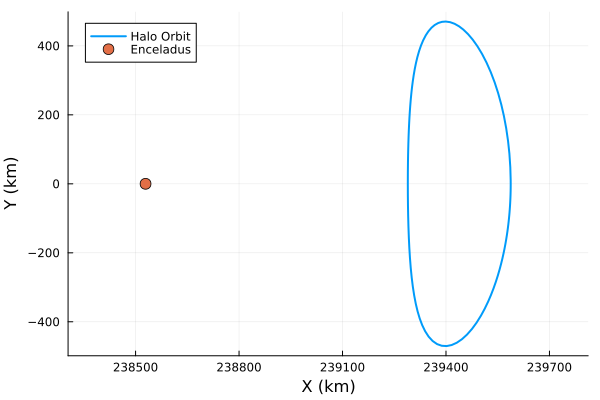

In [60]:
#If we integrate the richardson expansion on the CR3bp dynamics, it is not completely periodic because it is only an approximation 
#this is a plot of the integrated orbit

plot(all_state_final[1,:], all_state_final[2,:], xlabel="X (km)", ylabel="Y (km)", aspectratio=true, linewidth=2, label="Halo Orbit") 

scatter!([Saturn_Enceladus.pose_m2[1]*Saturn_Enceladus.position_scale], [0], label= "Enceladus", markersize=6)


In [61]:
#Check when the orbit leaves
periodic_initial_condition = all_state_final[:,1]

#Integrate the dynamics with the perturbed initial condtition
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_periodic = [periodic_initial_condition; Φ_0]

#integrate for 3.5 revs
solution_periodic = dynamics_integrate(Saturn_Enceladus, x_0_stm, 4.15*sol_t_final[end])

all_state_lp, stm_in_lp, sol_t_in_lp = get_state_stm(solution_periodic)

([239587.62743544072 239587.62736080837 … 238595.36578833792 238595.09841982048; 2.885776193752321e-15 -0.38997792038237183 … 9.613101287418234 9.652198467418659; … ; -4204.831491212667 -4204.830046806039 … 5469.637572473894 5459.748038490781; -9.769906950017222e-10 -1.3222068144222896 … -5494.849712780681 -5492.028591031678], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000006080534125 -1.1566889707589837e-10 … 3.929490444623238e-8 3.4664461987515593e-12; -2.3619618074380635e-10 0.9999998186556232 … 9.274518981504611e-5 -1.371380294392567e-15; … ; -7.640163653361465e-6 -0.003910592108533885 … 0.9999994596348373 -5.914613949462251e-11; 0.002417980705284708 -4.443577812736203e-7 … 4.196736620558153e-12 0.9999997528014017;;; 1.0000019424487898 -6.604323027499324e-10 … 1.25528983834541e-7 1.9792293126525714e-11; -1.3486046576074278e-9 0.9999994206890753 … 0.00016576587930004273 -1.3995018980837844e-14; … ; -2.4406783295168842e-5 -0.0069894984474745

In [62]:
periodic_initial_condition 

6-element Vector{Float64}:
 239587.62743544072
      2.885776193752321e-15
    226.1684428275936
     -9.467485007066476e-10
  -4204.831491212667
     -9.769906950017222e-10

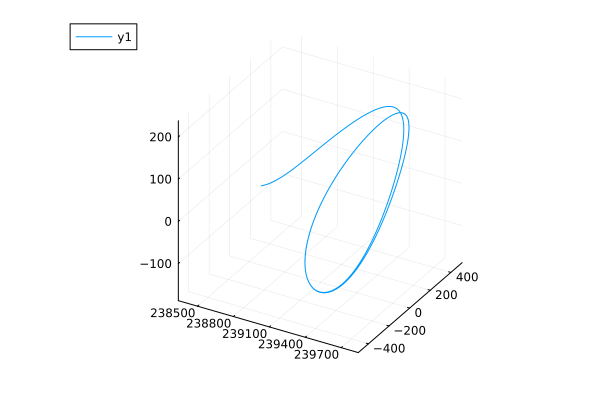

In [63]:
#the orbit after 4 revs 
plot(all_state_lp[1,:], all_state_lp[2,:], all_state_lp[3,:], aspectratio=true)



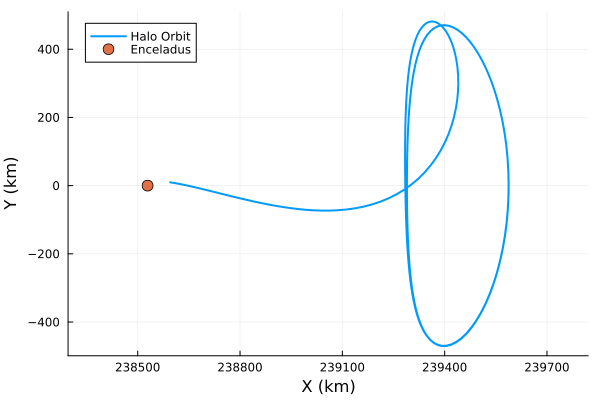

In [64]:
#the orbit after 4 revs 
plot(all_state_lp[1,:], all_state_lp[2,:], aspectratio=true, linewidth=2, label="Halo Orbit")

collision_risk = scatter!([Saturn_Enceladus.pose_m2[1]*Saturn_Enceladus.position_scale], [0], label= "Enceladus", markersize=6)

xlabel!("X (km)")
ylabel!("Y (km)")

In [65]:
#as seen above, after about 3.5 periods it begins to diverge from the periodic orbit 
#will formulate as a convex optimiztion problem to generate the station keeping 
#maneuvers

In [66]:
nx = 6 #number of states
nu = 3 #number of controls 

N_period = 41  #41 knot points per period per period

#the first state repeats with the last state
N_h = 81 #horizon 2 periods

#timestep 
Δt = (sol_t_final[end]/(N_period-1))

0.01688045685276023

In [67]:
#variables to save all the dynamics jacobians this is along 1 period of the reference orbit
all_Ad = zeros(6,6,N_period)
all_Bd = zeros(6,3,N_period)

6×3×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 41] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [68]:
using LinearAlgebra 

In [69]:
#this is the corrected period from the differential corrector
T_corrected = sol_t_final[end]

0.6752182741104091

In [70]:
(1/exp(3))*(1/exp(2))

0.006737946999085468

In [71]:
1/exp(5)

0.006737946999085467

In [72]:
#create even timesteps along the horizon 
horizon = LinRange(0, T_corrected, N_period)

41-element LinRange{Float64, Int64}:
 0.0, 0.0168805, 0.0337609, 0.0506414, …, 0.641457, 0.658338, 0.675218

In [73]:
#used to save the state transition matrix at each knot point
stm_times = zeros((6,6,N_period))

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0


In [74]:
#get the reference trajectory and state transition matrices at the correct times along the horizon 
reference_trajectory = zeros(nx, N_period)

for k=1:N_period

    reference_trajectory[:,k] = solution_final(horizon).u[k][1:6]
    
    #save the reference state transition matrices at the dedicated timesteps
    
    stm_times[:,:,k] = reshape(solution_final(horizon).u[k][7:end], (6,6)) 
        
end

In [75]:
#monodromy is the stm at the end of the periodic orbit
monodromy_eigen = eigen(stm_times[:,:,end])

stable_dir = real(monodromy_eigen.vectors[:,1])
unstable_dir = real(monodromy_eigen.vectors[:,end])
#find the eigen values of the monodromy

6-element Vector{Float64}:
 -0.08855910684994318
  0.02865744090018974
 -0.005939290756445591
 -0.8887776057510214
  0.4235137549309582
 -0.14836181247229713

In [76]:
#save the unstable directions in a matrix
unstable_directions = zeros(6,N_period)

6×41 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [77]:
#the unstable directions are then the stm at the timestep multiplied by the unstable direction found by the monodromy
for k = 1:N_period
    
    unstable_directions[:,k] = (stm_times[:,:,k]*unstable_dir)/norm(stm_times[:,:,k]*unstable_dir)
    
end

In [78]:
#unstable directions for the unstable manifolds along the orbit
unstable_directions

6×41 Matrix{Float64}:
 -0.0885591   -0.0868902   -0.0851866   …  -0.0901749   -0.0885591
  0.0286574    0.0305544    0.0327074       0.0270383    0.0286574
 -0.00593929  -0.00723924  -0.00836188     -0.00446516  -0.00593929
 -0.888778    -0.869275    -0.847692       -0.906178    -0.888778
  0.423514     0.461042     0.499174        0.387077     0.423514
 -0.148362    -0.152531    -0.154425    …  -0.141881    -0.148362

In [79]:
#save the manifolds when perturbation is added 
all_manifolds_plus = Matrix{Float64}[]

#save the manifolds when perturbation is subtracted 
all_manifolds_minus = Matrix{Float64}[]

Matrix{Float64}[]

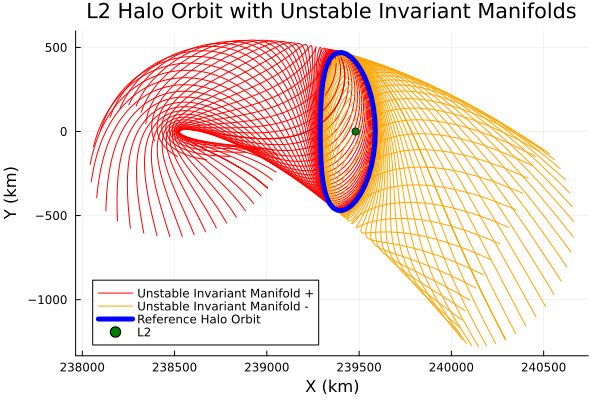

In [80]:
#plot the manifolds
#+ manifold to the right
# - manifold to the left

#epsilon multiplied by the perturbation when finding the manifolds 
epz = 3

plot(reference_trajectory[1,:], reference_trajectory[2,:], label=nothing)

all_state_mplus = 0

all_state_mminus = 0
for i=1:N_period
 
    initial_state_plus = reference_trajectory[:,i] + epz.*[unstable_directions[1:3,i];zeros(3)]

    initial_state_minus = reference_trajectory[:,i] - epz.*[unstable_directions[1:3,i];zeros(3)]

    inv_manifold_plus = just_dynamics_integrate(Saturn_Enceladus, initial_state_plus, 1.2*sol_t_final[end])

    inv_manifold_minus = just_dynamics_integrate(Saturn_Enceladus, initial_state_minus, 1.25*sol_t_final[end])

    all_state_mplus = get_state(inv_manifold_plus)

    all_state_mminus = get_state(inv_manifold_minus)
    

    push!(all_manifolds_plus, all_state_mplus)
    push!(all_manifolds_minus, all_state_mminus)


    plot!(all_state_mplus[1,:], all_state_mplus[2,:], color="red", label=nothing)
    plot!(all_state_mminus[1,:], all_state_mminus[2,:], color="orange", label=nothing)

end


plot!(all_state_mplus[1,:], all_state_mplus[2,:], color="red", label = "Unstable Invariant Manifold +")
plot!(all_state_mminus[1,:], all_state_mminus[2,:], color="orange", label = "Unstable Invariant Manifold -")

plot!(reference_trajectory[1,:], reference_trajectory[2,:], label="Reference Halo Orbit", linewidth = 5, xlabel = "X (km)", ylabel = "Y (km)", color="blue")
orbit_manifolds = scatter!([Saturn_Enceladus.XL2[1]*Saturn_Enceladus.position_scale], [0], markercolor = "green", label = "L2", legend=true, title = "L2 Halo Orbit with Unstable Invariant Manifolds")

In [81]:
#get the discrete dynamics jacobians for the entire reference trajectory along the knot points
for i=1:N_period

    all_Ad[:,:,i] = ForwardDiff.jacobian(x_-> RK4_integrator(Saturn_Enceladus, x_, zeros(3)), reference_trajectory[:,i])


    all_Bd[:,:,i] = ForwardDiff.jacobian(u_-> RK4_integrator(Saturn_Enceladus, reference_trajectory[:,i], u_), zeros(3))
    
    
end

In [82]:
#our horizon is 2 revolutions, therefore we need jacobians along the entire horizon
#will concatenate jacobians for two periods

all_Ad_1 = cat(all_Ad, all_Ad[:,:,2:end], dims=3)
all_Bd_1 = cat(all_Bd, all_Bd[:,:,2:end], dims=3)

6×3×81 Array{Float64, 3}:
[:, :, 1] =
  0.000142671   7.31073e-6   8.8045e-8
 -7.33849e-6    0.00014205  -2.94841e-9
  8.8045e-8    -2.94841e-9   0.00014228
  0.0169269     0.0012973    2.07624e-5
 -0.00130714    0.0167798   -1.84432e-6
  2.08426e-5   -2.41156e-7   0.0168343

[:, :, 2] =
  0.000142669   7.28339e-6    8.64853e-8
 -7.36584e-6    0.000142053  -8.64091e-9
  8.64853e-8   -8.64091e-9    0.000142279
  0.0169263     0.00129087    2.02514e-5
 -0.0013136     0.0167808    -3.15376e-6
  2.04337e-5   -1.58599e-6    0.016834

[:, :, 3] =
  0.000142665   7.2569e-6     8.34435e-8
 -7.39232e-6    0.000142059  -1.38034e-8
  8.34435e-8   -1.38034e-8    0.000142277
  0.0169252     0.00128467    1.94016e-5
 -0.00131984    0.0167824    -4.30514e-6
  1.96748e-5   -2.79927e-6    0.0168334

;;; … 

[:, :, 79] =
  0.000142669  7.36573e-6   8.64865e-8
 -7.28349e-6   0.000142053  8.61923e-9
  8.64865e-8   8.61923e-9   0.000142279
  0.0169266    0.00131038   2.06833e-5
 -0.00129407   0.0167802    

In [83]:
#compute backward ricatti recursion

#cost to go matrices for 16 revs
P = zeros((6,6,N_period+((N_period-1)*15))) #size state x state (6x6) 
K = zeros((3,6,N_period+((N_period-1)*15))) #size control x state (3x6)

#state cost weight matrix
Q = 1.0*Matrix(I,6,6).*1e-6

#terminal cost weight matrix
Qf = 1.0*Matrix(I,6,6).*1e-6

#control cost weight matrix
R = 1.0*Matrix(I,3,3).*1e-3

3×3 Matrix{Float64}:
 0.001  0.0    0.0
 0.0    0.001  0.0
 0.0    0.0    0.001

In [84]:
#variable to concatenate 16 sets of jacobians for 16 revolutions. this is to compute the recursion until we get a periodic pattern
all_Ad_16 = all_Ad
all_Bd_16 = all_Bd

6×3×41 Array{Float64, 3}:
[:, :, 1] =
  0.000142671   7.31073e-6   8.8045e-8
 -7.33849e-6    0.00014205  -2.94841e-9
  8.8045e-8    -2.94841e-9   0.00014228
  0.0169269     0.0012973    2.07624e-5
 -0.00130714    0.0167798   -1.84432e-6
  2.08426e-5   -2.41156e-7   0.0168343

[:, :, 2] =
  0.000142669   7.28339e-6    8.64853e-8
 -7.36584e-6    0.000142053  -8.64091e-9
  8.64853e-8   -8.64091e-9    0.000142279
  0.0169263     0.00129087    2.02514e-5
 -0.0013136     0.0167808    -3.15376e-6
  2.04337e-5   -1.58599e-6    0.016834

[:, :, 3] =
  0.000142665   7.2569e-6     8.34435e-8
 -7.39232e-6    0.000142059  -1.38034e-8
  8.34435e-8   -1.38034e-8    0.000142277
  0.0169252     0.00128467    1.94016e-5
 -0.00131984    0.0167824    -4.30514e-6
  1.96748e-5   -2.79927e-6    0.0168334

;;; … 

[:, :, 39] =
  0.000142669  7.36573e-6   8.64865e-8
 -7.28349e-6   0.000142053  8.61923e-9
  8.64865e-8   8.61923e-9   0.000142279
  0.0169266    0.00131038   2.06833e-5
 -0.00129407   0.0167802    

In [85]:
for i = 2:16
    all_Ad_16 = cat(all_Ad_16, all_Ad[:,:,2:end], dims = 3)
    all_Bd_16 = cat(all_Bd_16, all_Bd[:,:,2:end], dims = 3)
end

In [86]:
#Ricatti recursion over approximately 7 periods
P[:,:,end] = Qf

for k = reverse(1:640)
    #println(k)    
    K[:,:,k] = (R + all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k])\(all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:, k]) # ricatti recursion for both A and B matrices changing
    P[:,:,k] = Q + all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:,k] - all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k]*K[:,:,k]
        
end

In [87]:
P[:,:,1]

6×6 Matrix{Float64}:
 186.218    -62.4036    24.003     14.3338      4.63412     0.9652
 -62.4036    20.9268    -8.0501    -4.80409    -1.55139    -0.321354
  24.003     -8.0501     3.11107    1.84845     0.596441    0.121278
  14.3338    -4.80409    1.84845    1.10364     0.356147    0.0739231
   4.63412   -1.55139    0.596441   0.356147    0.116508    0.0242578
   0.9652    -0.321354   0.121278   0.0739231   0.0242578   0.00683386

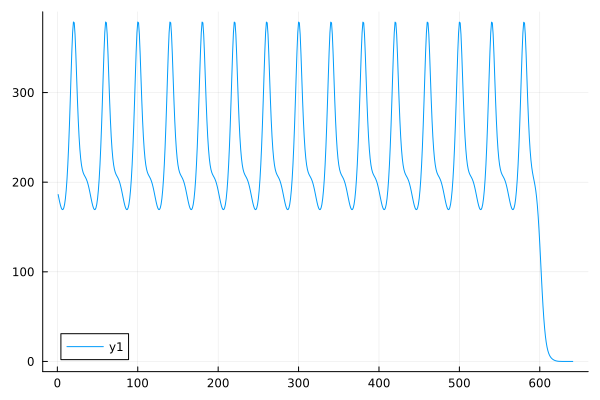

In [88]:
#can plot each diagonal element of the cost to go to see that it is periodic..
plot(P[1,1,:])
#plot(P[2,2,:])
#plot(P[3,3,:])
#plot(P[4,4,:])
#plot(P[5,5,:])
#plot(P[6,6,:])

In [89]:
#cost to go converges and is periodic! will get one orbit of the cost to go to make a constraint
V = P[:,:,1:41]

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 186.218    -62.4036    24.003     14.3338      4.63412     0.9652
 -62.4036    20.9268    -8.0501    -4.80409    -1.55139    -0.321354
  24.003     -8.0501     3.11107    1.84845     0.596441    0.121278
  14.3338    -4.80409    1.84845    1.10364     0.356147    0.0739231
   4.63412   -1.55139    0.596441   0.356147    0.116508    0.0242578
   0.9652    -0.321354   0.121278   0.0739231   0.0242578   0.00683386

[:, :, 2] =
 181.719     -68.8289    22.3521     14.2104      4.25664     0.707713
 -68.8289     26.0885    -8.47091    -5.38338    -1.60963    -0.265671
  22.3521     -8.47091    2.7617      1.7483      0.523048    0.0856493
  14.2104     -5.38338    1.7483      1.11148     0.332386    0.0549976
   4.25664    -1.60963    0.523048    0.332386    0.100926    0.0168392
   0.707713   -0.265671   0.0856493   0.0549976   0.0168392   0.00466386

[:, :, 3] =
 177.463     -74.5397    20.4156     14.0728      3.94232      0.437442
 -74.5397     31.

In [90]:
#cost to go matrices for 2 orbits worth of data
V_2orbits = cat(V, V[:,:,2:end], dims=3)

#unstable manifold directions for 2 orbits worth of data 

#we will save the negative of the unstable directions here since these are the ones that go to the right!
unstable_directions_2 = cat(-unstable_directions, -unstable_directions[:, 2:end], dims=2)

6×81 Matrix{Float64}:
  0.0885591    0.0868902    0.0851866   …   0.0901749    0.0885591
 -0.0286574   -0.0305544   -0.0327074      -0.0270383   -0.0286574
  0.00593929   0.00723924   0.00836188      0.00446516   0.00593929
  0.888778     0.869275     0.847692        0.906178     0.888778
 -0.423514    -0.461042    -0.499174       -0.387077    -0.423514
  0.148362     0.152531     0.154425    …   0.141881     0.148362

In [91]:
42*(1000/86400) 

0.4861111111111111

In [92]:
#define the injection error, how far we are off from the initial condition of the halo 

#in km and days 
x_initial_ref_scaled = [[1e-6, 0, 0]*Saturn_Enceladus.position_scale; [0,42.04831491212667, 0]]

6-element Vector{Float64}:
  0.238529
  0.0
  0.0
  0.0
 42.04831491212667
  0.0

In [93]:
#define the tube radii

#position radius
tube_pose_r = 100

#velocity radius 
tube_vel_r = 100

100

In [94]:
#find the axis lengths for each of these P matrices

all_axes_length = zeros(6, 81) 

for i= 1:81

    P_i = V_2orbits[:,:,i]

    vals_i = eigen(P_i).values  

    axes_length_i = 2 ./ (sqrt.(vals_i))

    all_axes_length[:,i] = axes_length_i    

end

#velocity axes lenghts are much smaller than position since a larger deviation will lead to a larger cost in the long run

In [95]:
#this is the reference trajectory for 2 orbits starting at the beginning
reference_trajectory2 = [reference_trajectory reference_trajectory[:,2:end]]


reference_trajectory_half = cat(reference_trajectory[:,21:end], reference_trajectory[:,2:21], dims=2)

#this is the reference trajectory starting at the half, timesteo 21
reference_trajectory2_2 = cat(reference_trajectory_half, reference_trajectory_half[:,2:end], dims=2)

6×81 Matrix{Float64}:
    2.39289e5      2.3929e5     2.39292e5  …     2.3929e5     2.39289e5
   -9.59401e-8    80.0752     157.408          -80.0752      -9.59401e-8
 -175.727       -172.391     -162.594         -172.391     -175.727
    2.52962e-6    86.1123     189.233          -86.1126       2.52962e-6
 4771.28        4688.71      4448.96          4688.71      4771.28
   -1.95801e-6   393.09       761.835      …  -393.089       -1.95801e-6

In [96]:
#this scales the axes on the cost-to-go ellipsoid. 
epsilon = 1

#parameter for the contingency constraint 
a = 0.5

0.5

In [97]:
#define the state constraint type

#"euc" for the Euclidean ball constraint 
constraint_type = "euc"

#"ctg" for the cost-to-go ellipsoid constraint 
#constraint_type = "ctg"

"euc"

In [98]:
using BenchmarkTools 

In [99]:
#one solve test
display("updating prob")
cons, X_1, U_1 = update_prob(Saturn_Enceladus, x_initial_ref_scaled, all_Ad_1, all_Bd_1, V_2orbits, unstable_directions_2, reference_trajectory2, constraint_type)
display("solving")
display(X_1)
Xm_1, Um_1 = solve_opt(cons, X_1, U_1, N_h)

"updating prob"

"solving"

Variable
size: (6, 81)
sign: real
vexity: affine
id: 549…427

([0.238529 0.2524942828413724 … 7.506453699532924 8.879803427503324; 0.0 0.3558576481547885 … -2.171471135957373 -2.8091071764159485; … ; 42.04831491212667 0.05185223836646718 … -32.8721114649421 -43.11568234189495; 0.0 0.10276353128359458 … 15.026794874201315 18.511388727769365], [-192.09737631504544 -78.35424217260105 … 1.664451470650524e-11 -5.878620330711828e-13; -2469.3818529114874 -5.748206137971073e-9 … 8.49842653394742e-12 1.6092202224950608e-11; 1.6717137527722273e-7 199.49372436532178 … 7.125822358340399e-12 -8.651737921304761e-12])

In [ ]:
#time how much time it takes to solve the problem

In [100]:
@btime Xm_1, Um_1 = solve_opt(cons, X_1, U_1, N_h) 

  21.944 ms (124376 allocations: 21.33 MiB)


([0.238529 0.2524942828413724 … 7.506453699532924 8.879803427503324; 0.0 0.3558576481547885 … -2.171471135957373 -2.8091071764159485; … ; 42.04831491212667 0.05185223836646718 … -32.8721114649421 -43.11568234189495; 0.0 0.10276353128359458 … 15.026794874201315 18.511388727769365], [-192.09737631504544 -78.35424217260105 … 1.664451470650524e-11 -5.878620330711828e-13; -2469.3818529114874 -5.748206137971073e-9 … 8.49842653394742e-12 1.6092202224950608e-11; 1.6717137527722273e-7 199.49372436532178 … 7.125822358340399e-12 -8.651737921304761e-12])

In [ ]:
Xm_1   

In [ ]:
Um_1 

In [ ]:
#check the constraint satisfaction on the manifold constraint
# constraint_satisfied = zeros(N_h)

# for i=1:N_h
#     constraint_satisfied[i] = dot(Xm[:,i], unstable_directions_2[:,i])
# end

In [ ]:
#all_Ad_1 and all_Bd_1 are the set of jacobians for two revoltions when we start at the beginning of the orbit 
#all_Ad_2 and all_Bd_2 are the set of jacobians for two revolutions when we start in the middle of the orbit 

all_Ad_half = cat(all_Ad[:,:,21:end], all_Ad[:,:,2:21], dims=3)
all_Bd_half = cat(all_Bd[:,:,21:end], all_Bd[:,:,2:21], dims=3)

all_Ad_2 = cat(all_Ad_half, all_Ad_half[:,:,2:end], dims = 3)
all_Bd_2 = cat(all_Bd_half, all_Bd_half[:,:,2:end], dims=3)

#also need to get the unstable directions and cost-to-go at the half point for two revoltions

#unstable directions is good. Need to fix V_2orbits
#saving the negative direction since this is the one that goes to the right!
unstable_directions_half = cat(-unstable_directions[:,21:end], -unstable_directions[:,2:21], dims=2)

#P is for the 16 orbits. Need the one for just 1 orbit
V_half = cat(V[:,:,21:end], V[:,:,2:21], dims=3)


#unstable directions if you start from the beginning
unstable_directions_2_1 = unstable_directions_2
#this is the unstable direction if you start at the half
unstable_directions_2_2 = cat(unstable_directions_half, unstable_directions_half[:,2:end], dims=2)


#cost to go if you start from the beginning
V_2orbits_1 = V_2orbits

#cost to go in you start at the half
V_2orbits_2 = cat(V_half, V_half[:,:,2:end], dims=3)

In [ ]:
#run the MPC 

orbit_count = 0

#number of orbits you want to plan go for
orbit_num = 100

halforbit_num = orbit_num*2 

#this is for each orbit plan

optimal_Δx = zeros(nx, N_period)
optimal_u = zeros(nu, N_period-1)

#data for all the orbits
all_optimal_Δx = zeros(nx, 21, halforbit_num)
all_optimal_x = zeros(nx, 21, halforbit_num)
all_optimal_u = zeros(nu, 20, halforbit_num)

#save the solution of each solve 
solution_xm = zeros(6, 81, halforbit_num)
solution_um = zeros(6, 80, halforbit_num)

 
for i=1:halforbit_num

    
    #if you start from the beginning use the appropriate set of jacobians
    if i%2 != 0
        #println("using jacobian set 1")
        all_Ad_k = all_Ad_1
        all_Bd_k = all_Bd_1
        unstable_directions_k = unstable_directions_2_1
        P_k = V_2orbits_1 
        reference_traj_k = reference_trajectory2       
    else
        #println("using jacobian set 2")
        all_Ad_k = all_Ad_2
        all_Bd_k = all_Bd_2
        unstable_directions_k = unstable_directions_2_2
        P_k = V_2orbits_2
        reference_traj_k = reference_trajectory2_2
    end
    
    #the zeros is the bias 
    cons, X, U = update_prob(Saturn_Enceladus, x_initial_ref_scaled, all_Ad_k, all_Bd_k, P_k, unstable_directions_k, reference_traj_k, constraint_type)
        
    Xm, Um = solve_opt(cons, X, U,N_h)

    solution_xm = Xm
    solution_um = Um
    
    #get the optimal controls for half a period (20 for this example)
    optimal_u = Um[:,1:20]
        
    #size N_period
        
    orbit_count += 1
    
    #rollout on the nonlinear dynamics
    if i%2 != 0
        
        #print("from beginning")
        xtraj_halfperiod = integrate_halfperiod(Saturn_Enceladus, reference_trajectory[:,1] + Xm[:,1], optimal_u)

        #this is the deviation from the reference
        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,1:21]
        
        #integrate the initial condition by all the optimal controls from the solver        
    else
        
        #println("from half")

        #this Xm is the one that just got computed
        xtraj_halfperiod = integrate_halfperiod(Saturn_Enceladus, reference_trajectory[:,21] + Xm[:,1], optimal_u)

        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,21:41] 
        #integrate the initial condition by all the optimal controls from the solver
        
    end
    
    all_optimal_x[:,:,orbit_count] = xtraj_halfperiod
    
    all_optimal_u[:,:,orbit_count] = optimal_u
    
    println("Half Revolution solved: ", i)
    
    #update the intiial condition for the next rev (has to be a delta)
    x_initial_ref_scaled = all_optimal_Δx[:,end, orbit_count]

    
end  

In [ ]:
all_optimal_u

In [ ]:
#format the outputin 3D arrays. put all the half trajectory solutions together 
all_optimal_x_formatted = zeros(6, N_period, orbit_num)
all_optimal_Δx_formatted = zeros(6, N_period, orbit_num)

In [ ]:
for i=1:orbit_num
    
    all_optimal_x_formatted[:,1:21,i] = all_optimal_x[:,:,(2*i-1)]
    
    #2:end is used to not repeat the same element twice
    all_optimal_x_formatted[:,22:end,i] = all_optimal_x[:,2:end,(2*i)]
    
    
    all_optimal_Δx_formatted[:,1:21,i] = all_optimal_Δx[:,:,(2*i-1)]
    
    all_optimal_Δx_formatted[:,22:end,i] = all_optimal_Δx[:,2:end,(2*i)]
    
end

In [ ]:
#format to 2D arrays 
all_xtraj = reshape(all_optimal_x_formatted, (6, N_period*orbit_num))

all_Δxtraj = reshape(all_optimal_Δx_formatted, (6, N_period*orbit_num))

all_utraj = reshape(all_optimal_u, (3, (N_period-1)*orbit_num))

In [ ]:
normz = zeros(4100)
for i=1:4100
    normz[i] = norm(all_Δxtraj[:,i])
end

In [ ]:
#state norm for the entire trajectory 
plot(normz )

In [ ]:
#horizon for a 10 revolution trajectory in days
days_range = range(0,409, 410)

days = collect(days_range)*Δt

In [ ]:
#this plots orbits 10-20

#range for control plots
plot_range_x = (-4e-6, 2e-6)
plot_range_y = (-1.5e-5, 1e-6)
plot_range_z = (-2e-6, 4e-6)


plot1 = plot(days, all_utraj[1,410:819]*1e3/86400^2, linewidth = 2,ylim = plot_range_x, title= "X Control")
plot2 = plot(days, all_utraj[2,410:819]*1e3/86400^2, linewidth = 2, ylim = plot_range_y, title= "Y Control", linecolor="red")
plot3 = plot(days , all_utraj[3,410:819]*1e3/86400^2, linewidth=2, ylim = plot_range_z, title= "Z Control", linecolor="green")


plot_layout = @layout [a;
                       b; 
                       c]

control1020 = plot(plot1, plot2, plot3, layout=plot_layout, legend=false, xlabel="Days", xlabelfontsize=8, ylabel="Force (N)", ylabelfontsize=8, ytickfontsize = 6)

In [ ]:
#plot the 100 orbits

plot(all_xtraj[1,:], all_xtraj[2,:], all_xtraj[3,:], label="MPC Trajectory", title="MPC Trajectory")

scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]], label="Start")

plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label = "Reference Trajectory")

In [ ]:
#this is already in units of km/(days)^2
scaled_control = all_utraj

In [ ]:
#integrate over the timestep to get the velocity cost in km/day
x_cost = sum(abs.(scaled_control[1,:]))*(Δt)
y_cost = sum(abs.(scaled_control[2,:]))*(Δt)
z_cost = sum(abs.(scaled_control[3,:]))*(Δt)

In [ ]:
#velocity cost in m/s
#dividing by 86400 to get into seconds bc currently it is in days

#units are good (checked in simulation_test)
x_cost_ms = x_cost*(1e3/86400)
y_cost_ms = y_cost*(1e3/86400)
z_cost_ms = z_cost*(1e3/86400)

display(x_cost_ms)
display(y_cost_ms)
display(z_cost_ms)

In [ ]:
all_cost = x_cost_ms + y_cost_ms + z_cost_ms  

In [ ]:
cost_per_rev = all_cost/orbit_num

In [ ]:
#Exclude the first 10 timesteps to fix the injection error
x_cost_good = sum(abs.(scaled_control[1,42:end]))*(Δt) *(1e3/86400)
y_cost_good = sum(abs.(scaled_control[2,42:end]))*(Δt) *(1e3/86400)
z_cost_good = sum(abs.(scaled_control[3,42:end]))*(Δt) *(1e3/86400)

display(x_cost_good)
display(y_cost_good)
display(z_cost_good)

In [ ]:
# #cost for 95 revs
all_cost_good = x_cost_good + y_cost_good + z_cost_good 

In [ ]:
#get the cost per year 

year_constant = 365/sol_t_final[end] 

year_cost = cost_per_rev*year_constant 

In [ ]:
#check the constraint for the manifold direction going to the right
constraint_check = zeros(4100)
for k=1:100
    for i=1:41

        constraint_check[41*(k-1)+i] = dot(-unstable_directions[:,i], all_Δxtraj[:, 41*(k-1)+i]) #> 0 

    end
end

In [ ]:
#first timestep not included in the constraint 
plot(constraint_check[2:end].>0)

In [ ]:
#save the 100 rev trajectory in a txt file
#writedlm("xtraj_saturn_enceladus_euclidean.txt", all_xtraj) 

In [ ]:
#save the reference in the \refs folder
#writedlm("reference_saturn_enceladus.txt", reference_trajectory) 